<a href="https://colab.research.google.com/github/rangelokk/Diplom/blob/main/Version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
import numpy as np
import seaborn as sns
import pandas as pd
import imgaug.augmenters as iaa
import imageio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import SGDClassifier
from PIL import Image

## Геля

In [ ]:
cat_col = ['dx_type', 'localization', 'sex']
nocat_col = ['age']
size = 32

### Загрузка данных

In [ ]:
# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

100%|██████████| 5.20G/5.20G [02:12<00:00, 42.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [ ]:
data = pd.read_csv(path + "/HAM10000_metadata.csv")
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Чб изображения 28*28 и метки

In [ ]:
image_data  = pd.read_csv(path + "/hmnist_28_28_L.csv")
image_data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
0,169,171,170,177,181,182,181,185,194,192,...,184,186,185,180,157,140,140,159,165,2
1,19,57,105,140,149,148,144,155,170,170,...,172,175,160,144,114,89,47,18,18,2
2,155,163,161,167,167,172,155,152,165,175,...,163,178,157,166,167,148,141,136,115,2
3,25,71,116,139,136,153,148,161,172,162,...,125,135,138,137,111,71,32,16,16,2
4,129,162,181,196,205,208,205,213,225,224,...,210,197,172,190,195,193,181,147,88,2


Цветные изображения 28*28 и метки

In [ ]:
image_data_rgb  = pd.read_csv(path + "/hmnist_28_28_RGB.csv")
image_data_rgb

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,183,165,181,182,165,180,184,166,182,188,...,208,185,187,208,186,186,206,187,189,0
10011,2,3,1,38,33,32,121,104,103,132,...,96,79,76,24,23,21,3,4,1,0
10012,132,118,118,167,149,149,175,156,160,184,...,204,181,178,181,159,153,172,151,145,0
10013,160,124,146,164,131,152,167,127,146,169,...,185,162,167,184,157,166,185,162,172,0


In [ ]:
def LoadImage(im):
  try:
    image = Image.open(path + '/HAM10000_images_part_1/'+im+'.jpg')
  except:
    image = Image.open(path + '/HAM10000_images_part_2/'+im+'.jpg')
  new_size = (size, size)
  resized_image = image.resize(new_size)
  return resized_image

In [ ]:
data['Image'] = data['image_id'].apply(LoadImage)
data

,lesion_id,image_id,dx,dx_type,age,sex,localization,Image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,<PIL.Image.Image image mode=RGB size=32x32 at ...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,<PIL.Image.Image image mode=RGB size=32x32 at ...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,<PIL.Image.Image image mode=RGB size=32x32 at ...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,<PIL.Image.Image image mode=RGB size=32x32 at ...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,<PIL.Image.Image image mode=RGB size=32x32 at ...
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,<PIL.Image.Image image mode=RGB size=32x32 at ...
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,<PIL.Image.Image image mode=RGB size=32x32 at ...
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,<PIL.Image.Image image mode=RGB size=32x32 at ...
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,<PIL.Image.Image image mode=RGB size=32x32 at ...


### Разделение датасета

In [ ]:
X = data.drop('image_id', axis=1)
X_Train, X_Test = train_test_split(X, test_size=0.25, random_state=42)
X_Test.reset_index(drop=True, inplace=True)
X_Train.reset_index(drop=True, inplace=True)

In [ ]:
X_Train

,lesion_id,dx,dx_type,age,sex,localization,Image
0,HAM_0003526,nv,follow_up,30.0,male,trunk,<PIL.Image.Image image mode=RGB size=12x12 at ...
1,HAM_0002996,nv,follow_up,45.0,female,trunk,<PIL.Image.Image image mode=RGB size=12x12 at ...
2,HAM_0006734,nv,consensus,50.0,female,back,<PIL.Image.Image image mode=RGB size=12x12 at ...
3,HAM_0000607,bkl,consensus,45.0,female,abdomen,<PIL.Image.Image image mode=RGB size=12x12 at ...
4,HAM_0003579,nv,consensus,60.0,male,back,<PIL.Image.Image image mode=RGB size=12x12 at ...
...,...,...,...,...,...,...,...
7506,HAM_0005460,nv,follow_up,50.0,female,lower extremity,<PIL.Image.Image image mode=RGB size=12x12 at ...
7507,HAM_0005615,nv,follow_up,45.0,female,trunk,<PIL.Image.Image image mode=RGB size=12x12 at ...
7508,HAM_0005773,nv,follow_up,45.0,female,lower extremity,<PIL.Image.Image image mode=RGB size=12x12 at ...
7509,HAM_0001053,bkl,consensus,55.0,female,chest,<PIL.Image.Image image mode=RGB size=12x12 at ...


In [ ]:
X_Test

,lesion_id,dx,dx_type,age,sex,localization,Image
0,HAM_0007180,mel,histo,65.0,male,face,<PIL.Image.Image image mode=RGB size=12x12 at ...
1,HAM_0007195,nv,histo,40.0,female,lower extremity,<PIL.Image.Image image mode=RGB size=12x12 at ...
2,HAM_0001835,mel,histo,65.0,male,back,<PIL.Image.Image image mode=RGB size=12x12 at ...
3,HAM_0000465,bkl,consensus,35.0,female,trunk,<PIL.Image.Image image mode=RGB size=12x12 at ...
4,HAM_0001720,nv,histo,45.0,male,abdomen,<PIL.Image.Image image mode=RGB size=12x12 at ...
...,...,...,...,...,...,...,...
2499,HAM_0002747,nv,follow_up,60.0,female,lower extremity,<PIL.Image.Image image mode=RGB size=12x12 at ...
2500,HAM_0001209,nv,consensus,NaN,unknown,unknown,<PIL.Image.Image image mode=RGB size=12x12 at ...
2501,HAM_0003405,nv,follow_up,35.0,female,trunk,<PIL.Image.Image image mode=RGB size=12x12 at ...
2502,HAM_0003373,bcc,histo,65.0,male,back,<PIL.Image.Image image mode=RGB size=12x12 at ...


### Аугментация

<Axes: xlabel='dx', ylabel='percent'>

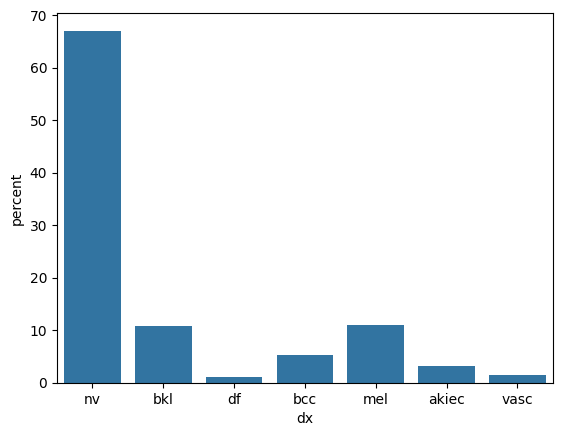

In [ ]:
sns.countplot(X_Train, x="dx", stat="percent")

In [ ]:
def Augmentation(dat, apply_dx):
  new_data = pd.DataFrame()
  rotations = [
      iaa.Affine(rotate=90),
      iaa.Affine(rotate=180),
      iaa.Affine(rotate=270)
      ]
  for index, line in dat.iterrows():
    if(line['dx']!='nv'):
      image_np = np.array(line['Image'])
      augmented_images = [(rotation(image=image_np)) for rotation in rotations]
      for aug_image in augmented_images:
        new_line = line.copy()
        new_line['Image'] = Image.fromarray(aug_image)
        new_data = pd.concat([new_data, new_line.to_frame().T], ignore_index=True)
  return new_data

In [ ]:
Aug_Data=Augmentation(X_Train, 'apply_dx')
Aug_Data

,lesion_id,dx,dx_type,age,sex,localization,Image
0,HAM_0000607,bkl,consensus,45.0,female,abdomen,<PIL.Image.Image image mode=RGB size=12x12 at ...
1,HAM_0000607,bkl,consensus,45.0,female,abdomen,<PIL.Image.Image image mode=RGB size=12x12 at ...
2,HAM_0000607,bkl,consensus,45.0,female,abdomen,<PIL.Image.Image image mode=RGB size=12x12 at ...
3,HAM_0000907,bkl,histo,75.0,male,ear,<PIL.Image.Image image mode=RGB size=12x12 at ...
4,HAM_0000907,bkl,histo,75.0,male,ear,<PIL.Image.Image image mode=RGB size=12x12 at ...
...,...,...,...,...,...,...,...
7417,HAM_0004988,bkl,histo,75.0,male,lower extremity,<PIL.Image.Image image mode=RGB size=12x12 at ...
7418,HAM_0004988,bkl,histo,75.0,male,lower extremity,<PIL.Image.Image image mode=RGB size=12x12 at ...
7419,HAM_0001053,bkl,consensus,55.0,female,chest,<PIL.Image.Image image mode=RGB size=12x12 at ...
7420,HAM_0001053,bkl,consensus,55.0,female,chest,<PIL.Image.Image image mode=RGB size=12x12 at ...


In [ ]:
X_Train=pd.concat([X_Train, Aug_Data], ignore_index=True)
X_Train

,lesion_id,dx,dx_type,age,sex,localization,Image
0,HAM_0003526,nv,follow_up,30.0,male,trunk,<PIL.Image.Image image mode=RGB size=12x12 at ...
1,HAM_0002996,nv,follow_up,45.0,female,trunk,<PIL.Image.Image image mode=RGB size=12x12 at ...
2,HAM_0006734,nv,consensus,50.0,female,back,<PIL.Image.Image image mode=RGB size=12x12 at ...
3,HAM_0000607,bkl,consensus,45.0,female,abdomen,<PIL.Image.Image image mode=RGB size=12x12 at ...
4,HAM_0003579,nv,consensus,60.0,male,back,<PIL.Image.Image image mode=RGB size=12x12 at ...
...,...,...,...,...,...,...,...
14928,HAM_0004988,bkl,histo,75.0,male,lower extremity,<PIL.Image.Image image mode=RGB size=12x12 at ...
14929,HAM_0004988,bkl,histo,75.0,male,lower extremity,<PIL.Image.Image image mode=RGB size=12x12 at ...
14930,HAM_0001053,bkl,consensus,55.0,female,chest,<PIL.Image.Image image mode=RGB size=12x12 at ...
14931,HAM_0001053,bkl,consensus,55.0,female,chest,<PIL.Image.Image image mode=RGB size=12x12 at ...


<Axes: xlabel='dx', ylabel='percent'>

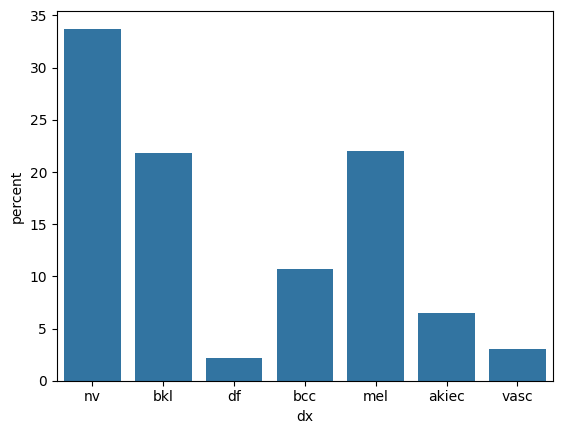

In [ ]:
sns.countplot(X_Train, x="dx", stat="percent")

### Сборка данных датасета

In [ ]:
def preprocessing_X (dop_data_cat = None, dop_data_nocat = None): #
  X = pd.DataFrame()
  if dop_data_cat is not None and not dop_data_cat.empty:
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder(sparse_output=False)
    data_new = ohe.fit_transform(dop_data_cat.values)
    columns = ohe.get_feature_names_out(input_features=dop_data_cat.columns)
    X = pd.concat([X, pd.DataFrame(data_new, columns=columns)], axis=1)
  if dop_data_nocat is not None and not dop_data_nocat.empty:
    dop_data_nocat/=85.
    X = pd.concat([X, dop_data_nocat], axis=1)
  return X

In [ ]:
def UnpackImages(array, size):
    num_images = len(array)
    data_image = np.zeros((num_images, 3 * size**2), dtype=np.uint8)
    for i, im in enumerate(array):
        pixels = np.array(im.getdata()).flatten()
        data_image[i] = pixels
    col = [f'pixel{str(i).zfill(4)}' for i in range(3 * size**2)]
    print("Распаковка успешна!")
    return pd.DataFrame(data=data_image / 255., columns=col)

In [ ]:
X_test = pd.concat([UnpackImages(X_Test['Image'], size), preprocessing_X(
                           X_Test[cat_col] if cat_col is not None else None,
                           X_Test[nocat_col] if nocat_col is not None else None)], axis=1)
X_test

Распаковка успешна!


,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity,sex_female,sex_male,sex_unknown,age
0,0.615686,0.309804,0.431373,0.603922,0.270588,0.388235,0.631373,0.290196,0.431373,0.686275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.764706
1,0.839216,0.654902,0.678431,0.843137,0.647059,0.666667,0.847059,0.647059,0.647059,0.854902,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.470588
2,0.803922,0.498039,0.482353,0.819608,0.505882,0.486275,0.831373,0.537255,0.517647,0.854902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.764706
3,0.803922,0.592157,0.631373,0.815686,0.603922,0.643137,0.839216,0.627451,0.662745,0.835294,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.411765
4,0.474510,0.372549,0.396078,0.529412,0.415686,0.439216,0.537255,0.415686,0.419608,0.541176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.529412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,0.807843,0.509804,0.654902,0.803922,0.498039,0.631373,0.815686,0.501961,0.639216,0.815686,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.705882
2500,0.513725,0.411765,0.478431,0.584314,0.490196,0.568627,0.588235,0.494118,0.564706,0.564706,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN
2501,0.992157,0.588235,0.631373,0.992157,0.592157,0.631373,0.996078,0.603922,0.662745,0.996078,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.411765
2502,0.388235,0.223529,0.290196,0.470588,0.298039,0.356863,0.533333,0.337255,0.380392,0.607843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.764706


In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2504 entries, 0 to 2503
Columns: 455 entries, pixel0000 to age
dtypes: float16(432), float64(23)
memory usage: 2.5 MB


In [ ]:
X_train = preprocessing_X(UnpackImages(X_Train['Image']), X_Train[cat_col], X_Train[nocat_col])
X_train

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity,sex_female,sex_male,sex_unknown,age
0,0.964706,0.658824,0.690196,0.968627,0.686275,0.713725,0.968627,0.682353,0.721569,0.968627,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.352941
1,0.878431,0.541176,0.607843,0.898039,0.560784,0.615686,0.909804,0.572549,0.635294,0.921569,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.529412
2,0.721569,0.584314,0.568627,0.733333,0.596078,0.580392,0.745098,0.611765,0.611765,0.749020,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.588235
3,0.882353,0.741176,0.768627,0.901961,0.749020,0.776471,0.913725,0.745098,0.768627,0.925490,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.529412
4,0.733333,0.439216,0.490196,0.784314,0.498039,0.541176,0.792157,0.521569,0.588235,0.776471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.705882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14928,0.607843,0.419608,0.478431,0.819608,0.639216,0.670588,0.827451,0.670588,0.721569,0.835294,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.882353
14929,0.619608,0.490196,0.545098,0.780392,0.647059,0.690196,0.803922,0.674510,0.717647,0.800000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.882353
14930,0.250980,0.180392,0.207843,0.403922,0.349020,0.384314,0.533333,0.478431,0.517647,0.580392,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.647059
14931,0.400000,0.321569,0.313725,0.588235,0.505882,0.509804,0.639216,0.560784,0.592157,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.647059


In [ ]:
class_labels = {
    'akiec': 0,
    'bcc': 1,
    'bkl': 2,
    'df': 3,
    'nv': 4,
    'vasc': 5,
    'mel': 6
}
Y_train = X_Train['dx'].replace(class_labels)
Y_train

<ipython-input-21-7a41d8e5ac34>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_train = X_Train['dx'].replace(class_labels)


,dx
0,4
1,4
2,4
3,2
4,4
...,...
7506,4
7507,4
7508,4
7509,2


In [ ]:
Y_test = X_Test['dx'].replace(class_labels)
Y_test

<ipython-input-22-0e6f1465045b>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y_test = X_Test['dx'].replace(class_labels)


,dx
0,6
1,4
2,6
3,2
4,4
...,...
2499,4
2500,4
2501,4
2502,1


### Функции сборки и разборки данных (Необязательны к запуску)

In [ ]:
def pack_img(size, array):
  pixels = []
  for i in range(size**2):
      r = array[0][i*3]    # Красный
      g = array[0][i*3+1] # Зеленый
      b = array[0][i*3+2] # Синий
      pixels.append([r, g, b])

  # Преобразуем в массив NumPy и меняем форму для отображения
  image_array = np.array(pixels).reshape(size, size, 3)

  # Отображаем изображение
  plt.imshow(image_array.astype(np.uint8))
  plt.axis('off') # Отключаем оси
  plt.show()

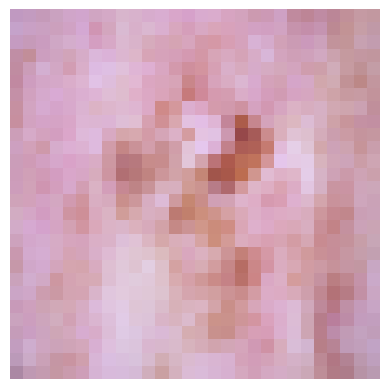

In [ ]:
pack_img(28, image_data_rgb.iloc[0].values.reshape(1, -1))

In [ ]:
def unpack_data(image, age, sex, localization, dx_type):
  new_size = (size, size)
  resized_image = image.resize(new_size)
  pixels = list(resized_image.getdata())
  image_array = np.array(pixels).reshape(3*size*size)
  image_array= image_array/255.
  pad_width = len(X_train.columns) - len(image_array)
  print(pad_width)
  padded_arr = np.pad(image_array, (0, pad_width), mode='constant', constant_values=0.0)
  padded_arr = np.array(padded_arr).reshape(1, len(X_train.columns))
  new_data=pd.DataFrame(columns = X_train.columns, data=padded_arr)

  new_data['age'] = age/85.
  new_data['sex_'+sex]= 1.0
  new_data['localization_'+localization]= 1.0
  new_data['dx_type_'+dx_type]= 1.0
  return new_data

In [ ]:
unpack_data(Image.open(path + '/HAM10000_images_part_1/' + data['image_id'][0] + '.jpg'), 50, 'male', 'neck', 'histo')

23


,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity,sex_female,sex_male,sex_unknown,age
0,0.772549,0.615686,0.760784,0.8,0.635294,0.760784,0.823529,0.639216,0.776471,0.839216,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.588235


## Лиза

❗ Запустить блок "Геля" перед обучением модели!

### Модель OVO, не работает!

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, Y_train)

InvalidParameterError: The 'tol' parameter of SGDClassifier must be a float in the range [0.0, inf) or None. Got -inf instead.

In [ ]:
val_probs = ovo_clf.predict_proba(X_test)[:, 1]
roc_auc_score(Y_test, val_probs)

AttributeError: 'OneVsOneClassifier' object has no attribute 'predict_proba'

### Случайный лес

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
model = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(model, X_train, Y_train, cv=3,
                                    method="predict_proba")

In [ ]:
model.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [ ]:
val_probs = model.predict_proba(X_test)
roc_auc = roc_auc_score(Y_test, val_probs, multi_class='ovr')
print(roc_auc)

0.782829138673093


###Добавляю оценки (Лиза)

In [ ]:
print("Пробую")

Пробую


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6813099041533547


In [ ]:
precision = precision_score(Y_test, y_pred, average='weighted')
print(f"Precision: {precision}")

Precision: 0.7255955941946959


In [ ]:
recall = recall_score(Y_test, y_pred, average='weighted')
print(f"Recall: {recall}")

Recall: 0.6813099041533547


In [ ]:
f1_scor = f1_score(Y_test, y_pred, average='weighted')
print(f"F1_score: {f1_scor}")

F1_score: 0.6963791206345058


In [ ]:
mse = mean_squared_error(Y_test, y_pred)
print(f"Mean Squared Error [MSE]: {mse}")

Mean Squared Error [MSE]: 2.355031948881789


In [ ]:
mae = mean_absolute_error(Y_test, y_pred)
print(f"Mean Absolute Error [MAE]: {mae}")

Mean Absolute Error [MAE]: 0.777555910543131


###Матрица неточностей (Лиза)

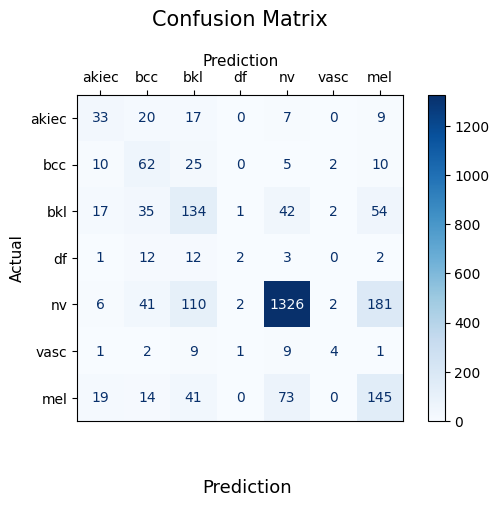

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

class_names = ['akiec','bcc','bkl','df','nv','vasc','mel']

cm = confusion_matrix(Y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)
#Customizations
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()

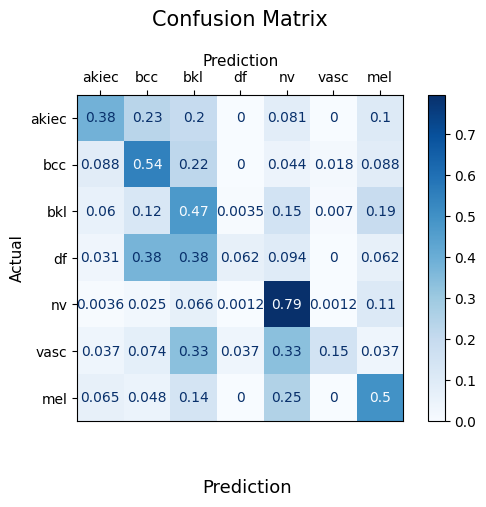

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

class_names = ['akiec','bcc','bkl','df','nv','vasc','mel']

cm = confusion_matrix(Y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6])
row_sum = cm.sum(axis=1, keepdims=True)
cm =cm / row_sum
##np.fill_diagonal(cm, 0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)
#Customizations
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()

In [ ]:
top_feature = pd.DataFrame()
top_feature['feature'] = X_test.columns
top_feature['score'] = model.feature_importances_
top_feature.sort_values('score', ascending=False).head(10)

,feature,score
435,dx_type_histo,0.033479
434,dx_type_follow_up,0.025634
454,age,0.018555
3,pixel0003,0.013578
433,dx_type_consensus,0.011526
196,pixel0196,0.010398
164,pixel0164,0.009851
233,pixel0233,0.009623
236,pixel0236,0.009386
0,pixel0000,0.008595


In [ ]:
top_feature.sort_values('score', ascending=True).head(10)

,feature,score
440,localization_ear,0.000000
437,localization_acral,0.000000
453,sex_unknown,0.000000
443,localization_genital,0.000016
446,localization_neck,0.000117
442,localization_foot,0.000131
439,localization_chest,0.000177
447,localization_scalp,0.000191
444,localization_hand,0.000270
452,sex_male,0.000402


In [ ]:
fea = top_feature.T
fea = fea[range(3*size**2, len(fea.columns))]
fea_score = pd.DataFrame(data=fea.iloc[1].values.reshape(1, -1), columns = fea.iloc[0])
fea_score

feature,dx_type_confocal,dx_type_consensus,dx_type_follow_up,dx_type_histo,localization_abdomen,localization_acral,localization_back,localization_chest,localization_ear,localization_face,...,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity,sex_female,sex_male,sex_unknown,age
0,0.000913,0.011526,0.025634,0.033479,0.000573,0.0,0.001616,0.000177,0.0,0.00246,...,0.001418,0.000117,0.000191,0.000823,0.00048,0.000517,0.000545,0.000402,0.0,0.018555


## Катя

Здесь будут примеры работы классификатора с процентами. Просьба запустить предыдущие блоки

4 - nv  
3 - df  
5 - vasc  
0 - akiec  
1 - bcc  
6 - mel  
2 - bkl  

In [ ]:
# закидываем названий классов
class_names = {
    0: 'akiec',
    1: 'bcc',
    2: 'bkl',
    3: 'df',
    4: 'nv',
    5: 'vasc',
    6: 'mel'
}

#ТЕСТ
index = np.random.randint(len(X_test))  # предсказание для ОДНОГО случайного индекс из тестового набора
#sample = X_test[index].reshape(1, -1) не работает ошибка
sample = X_test.iloc[index].values.reshape(1, -1)  #доступ к строкам
sample_prob = model.predict_proba(sample)  #вероятности диагнозов в массиве

# Итоговый вывод
for i, prob in enumerate(sample_prob[0]):
    print(f"{class_names[i]}: {prob*100:.2f}%")
predicted_class = np.argmax(sample_prob)
print(f"Для {index} возможный диагноз: {class_names[predicted_class]}")

akiec: 0.00%
bcc: 0.00%
bkl: 0.00%
df: 0.00%
nv: 80.00%
vasc: 0.00%
mel: 20.00%
Для 2173 возможный диагноз: nv


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


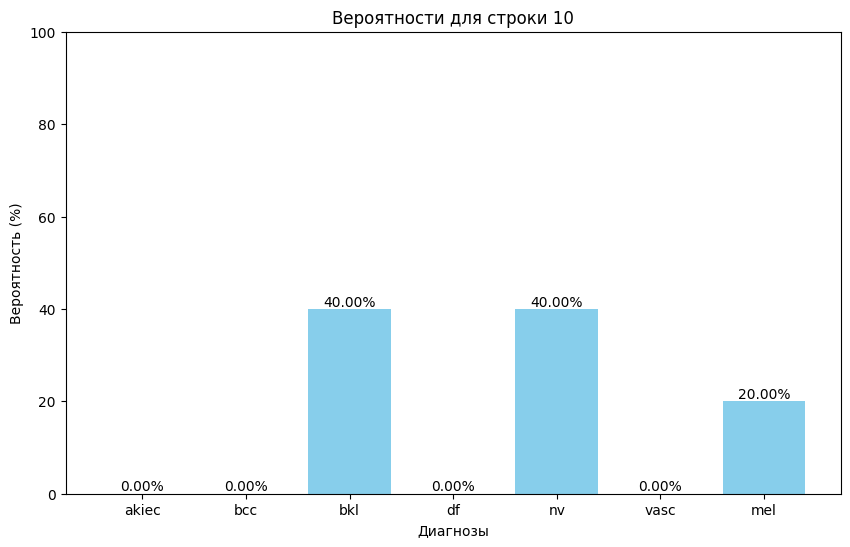

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(class_names.values(), sample_prob[0] * 100, color='skyblue')
plt.xlabel('Диагнозы')
plt.ylabel('Вероятность (%)')
plt.title(f'Вероятности для строки {index}')
plt.ylim(0, 100)
for i, prob in enumerate(sample_prob[0]):
    plt.text(i, prob * 100, f"{prob*100:.2f}%", ha='center', va='bottom')
plt.show()

In [ ]:
#Если известен индекс изображения, для которого нужен диагноз
index = int(input('Введите номер индекса: '))
sample = X_test.iloc[index].values.reshape(1, -1)  #доступ к строкам
sample_prob = model.predict_proba(sample)  #вероятности диагнозов в массиве

# Итоговый вывод
for i, prob in enumerate(sample_prob[0]):
    print(f"{class_names[i]}: {prob*100:.2f}%")
predicted_class = np.argmax(sample_prob)
print(f"Для {index} возможный диагноз: {class_names[predicted_class]}")

Введите номер индекса: 10
akiec: 0.00%
bcc: 0.00%
bkl: 40.00%
df: 0.00%
nv: 40.00%
vasc: 0.00%
mel: 20.00%
Для 10 возможный диагноз: bkl


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
#Тут пипец, оч много
for index in range(len(X_test)):
    sample = X_test.iloc[index].values.reshape(1, -1)  # предсказание для ВСЕХ строк из тестового набора
    sample_prob = model.predict_proba(sample)

    print(f"\nСтрока {index}:")
    for i, prob in enumerate(sample_prob[0]):
        print(f"{class_names[i]}: {prob*100:.2f}%")

    predicted_class = np.argmax(sample_prob)
    print(f"Диагноз: {class_names[predicted_class]}")